In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM\ project/LSTM/sector_analysis(tech)

/content
/content/drive/MyDrive/LSTM project/LSTM/sector_analysis(tech)


# Make models

In [3]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c='High', output_i=1, train_size=754, time_step=60, epochs=30): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  print("finish split data")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if V:
    print("volume=TRUE")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss1=StandardScaler()
    ss_others=ss1.fit_transform(training_set_others)
    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    
    if output_i==5:
      ind=[i for i in range((len(v)-1)*len(c), len(v)*len(c))]
    else:
      ind=[i for i in range(output_i, training_set_others.shape[1], len(v)-1)]
    print(f"ind={ind}")

    for j in range(time_step, 754):
      X_train.append(concat[j-time_step: j, :])
      for k in range(len(ind)):
        y_trains.append(concat[j, ind[k]])

  else:
    training_set=np.hstack((data for data in train_data))
    print(f"training_set={training_set.shape}")
    ss1=StandardScaler()
    ss_all=ss1.fit_transform(training_set)

    ind=[i for i in range(output_i, training_set.shape[1], len(v))]
    print(f"ind={ind}")

    for j in range(time_step, 754):
      X_train.append(ss_all[j-time_step: j, :])
      for k in range(len(c)):
        y_trains.append(ss_all[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  print("finish making X_train and y_trains")

  #3. train models
  y_trains2=[]
  for y in range(len(c)):
    y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
    y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2[0].shape}")

  
  model_lists = []
  for l in range(len(y_trains2)):
    print(f"{l+1}/{len(y_trains2)}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs = epochs, batch_size = 32)
    model_lists.append(model)
    print("")
  print("finish making models")
  return model_lists, y_trains2



# Make preds

In [11]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c='High', output_i=1, train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)):
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  print(f"inputs = {np.array(inputs).shape}")
# con=(312, 80)
# ss_lists=21

  #ここでtargetとvolume以外のラベルを獲得
  if V:
    if output_i != len(v):
      ex = [i for i in range(len(v)-1)]
      ex.pop(output_i) #ここでvolumeを除く
      print(ex)
    else: 
      ex = [i for i in range(len(v)-1)]
  else: 
    ex = [i for i in range(len(v))]
    ex.pop(output_i)

  con = np.hstack((inp[:, ex] for inp in inputs))
  print(f"con={con.shape}")
  
  if V:
    if output_i == len(v): # target=volume
      ss_lists = [tar[:, output_i-1].reshape(-1, 1) for tar in inputs]
    else:
      ss_lists = [tar[:, output_i-1].reshape(-1, 1) for tar in inputs] + [vol[:, -1].reshape(-1, 1) for vol in inputs]

    if con.shape[1] !=0:
      ss_lists.append(con)
    print(f"ss_lists={len(ss_lists)}")

  else: 
    ss_lists = [tar[:, output_i-1].reshape(-1, 1) for tar in inputs]
    ss_lists.append(con)
    print(f"ss_lists={len(ss_lists)}")   

  x = []
  ss = []
  for i in range(len(ss_lists)):
    s=StandardScaler() 
    print(ss_lists[i].shape)
    m=s.fit_transform(ss_lists[i])
    x.append(m)
    ss.append(s)
  inputs2=np.hstack((sx for sx in x))
  # print(f"inputs2={inputs2}")

  X_test = []
  # use all components as a imputs for testing
  for n in range(60, 312):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")

  preds = []
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))

  for p in range(len(y_trains2)):
    preds[p] = ss[p].inverse_transform(preds[p])

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[sc.iloc[train_size:, output_i+1: output_i+2] for sc in c]
  print("1")
  R2=nl
  
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    print("2")
    print(f"actual lists={actual_lists[p].shape}, preds_list={preds[p].shape}")
    plt.plot(c[p].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[p].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    print("3")
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    plt.title(nl[p])
    plt.xlabel('Time series')
    plt.ylabel('Stock Price')
    
    # use correlation
    print(f"R2[{R2[p]}]={r2_score(actual_lists[p], preds[p].flatten())}")
    plt.legend()
    plt.show()
  
  # #6. Make confusion matrix

  # columns = nl # labeling 
  # # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # # Predictions
  # print("Prediction")
  # prd=[p for p in preds]
  # Preds= pd.DataFrame(np.concatenate(prd, axis=1))
  # Preds.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# "Experiments"
###Sector: Technology
### Criteria: Profits/Employees 

In [5]:
# sector-> Food & Drug store(2017/01/01~2020/12/31) 
import pandas as pd
df1=pd.read_csv("FB.csv") 
df2=pd.read_csv("AAPL.csv")  
df3=pd.read_csv("MSFT.csv")
df4=pd.read_csv("TSM.csv") 
df5=pd.read_csv("TCEHY.csv")  
df6=pd.read_csv("INTC.csv")  
df7=pd.read_csv("CSCO.csv")  
df8=pd.read_csv("ORCL.csv")    
df9=pd.read_csv("HP.csv")  
df10=pd.read_csv("TMO.csv") 
df11=pd.read_csv("SONY.csv") 
df12=pd.read_csv("SAP.csv") 
df13=pd.read_csv("DELL.csv") 
df14=pd.read_csv("IBM.csv") 
df15=pd.read_csv("HPE.csv") 
df16=pd.read_csv("ACN.csv")  
df17=pd.read_csv("PCRFY.csv") 
df18=pd.read_csv("CAJ.csv") 
df19=pd.read_csv("HNHPF.csv") 
df20=pd.read_csv("HTHIY.csv") 
print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, 
      df11.shape, df12.shape, df13.shape, df14.shape, df15.shape, df16.shape, df17.shape, df18.shape, df19.shape, df20.shape)

df18.head(100)

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.180000,28.440001,28.150000,28.420000,28.420000,562400
1,2017-01-04,28.580000,28.700001,28.570000,28.700001,28.700001,343000
2,2017-01-05,28.740000,28.920000,28.740000,28.889999,28.889999,195800
3,2017-01-06,28.610001,28.690001,28.559999,28.559999,28.559999,164600
4,2017-01-09,28.660000,28.660000,28.549999,28.549999,28.549999,226000
...,...,...,...,...,...,...,...
95,2017-05-19,33.919998,33.970001,33.820000,33.950001,33.950001,239700
96,2017-05-22,34.070000,34.070000,33.939999,33.990002,33.990002,941200
97,2017-05-23,34.070000,34.070000,33.880001,33.919998,33.919998,258000
98,2017-05-24,33.919998,33.939999,33.830002,33.930000,33.930000,116000


In [7]:
c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20]
nl=["Facebook", "Apple", "Microsoft", "TSMC", "Tencent", "Intel", "Cisco", "Oracle", "HP", "Themo", 
    "Sony", "SAP", "Dell", "IBM", "HPE", "Accenture", "Panasonic", "Canon", "Hon Hai", "Hitachi"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
# Basically, we can remove "Date" and "Adj Close"
v=[1, 2, 3, 4, 6]  # item' index chosen as imputs
output_c='Volume' # output item
output_i=items[output_c]-1

# V means whether "Volume" may be included or not
if 6 not in v:
  V=False
else: V=True

In [8]:
o1, o2 = make_models(c, nl, v, V=V, output_c=output_c, output_i=output_i, train_size=754, time_step=60, epochs=1)

train_data=(20, 754, 5), test_data=(20, 252, 5)
finish split data
volume=TRUE
ind=[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
X_train=(694, 60, 100), y_trains=(13880,)
finish making X_train and y_trains
y_trains2=(694,)
1/20
22/22 [==============================] - 9s 118ms/step - loss: 0.7709

2/20
22/22 [==============================] - 9s 108ms/step - loss: 1.0045

3/20
22/22 [==============================] - 9s 111ms/step - loss: 0.9612

4/20
22/22 [==============================] - 9s 113ms/step - loss: 1.0261

5/20
22/22 [==============================] - 9s 118ms/step - loss: 0.9835

6/20
22/22 [==============================] - 9s 112ms/step - loss: 0.9698

7/20
22/22 [==============================] - 9s 115ms/step - loss: 0.8940

8/20
22/22 [==============================] - 8s 111ms/step - loss: 1.0595

9/20
22/22 [==============================] - 9s 116ms/step - loss: 1.1198

10/20
22/22 [==============================] - 9s 114ms/ste

train_data=(20, 754, 5), test_data=(20, 252, 5)
inputs = (20, 312, 5)
con=(312, 80)
ss_lists=21
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 80)
X_test=(252, 60, 100)
finish making predictions
1
2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Facebook]=-0.11676353638322667


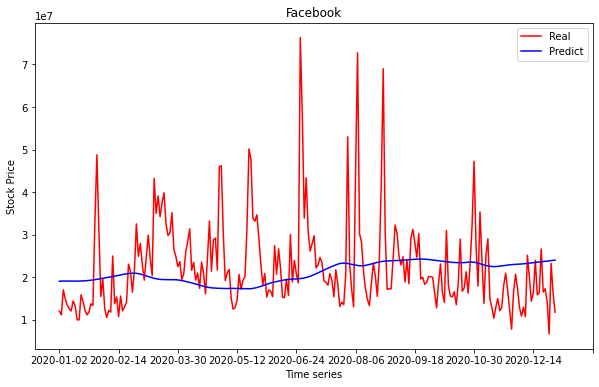

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Apple]=-0.07302659810666534


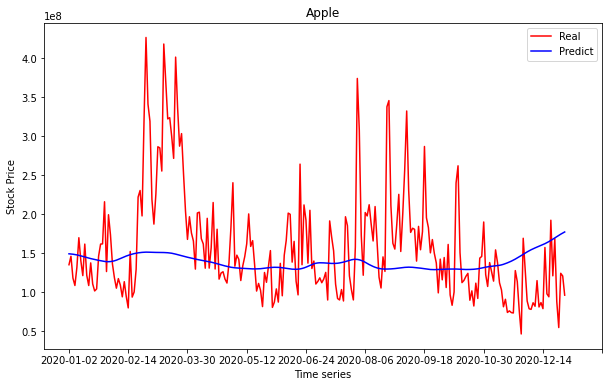

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Microsoft]=-0.7389698051433213


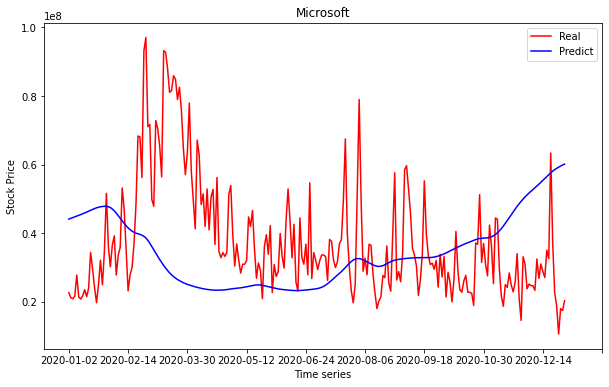

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[TSMC]=-0.22646980664994776


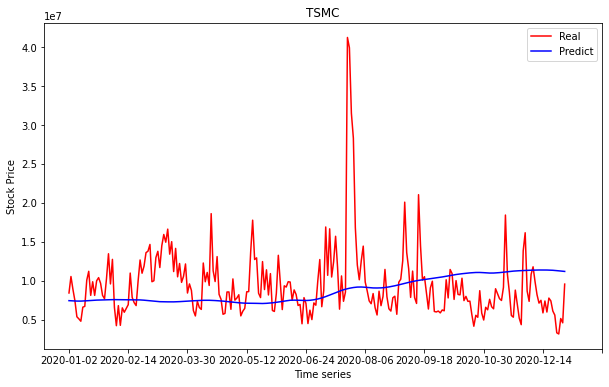

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Tencent]=-0.20782233713479514


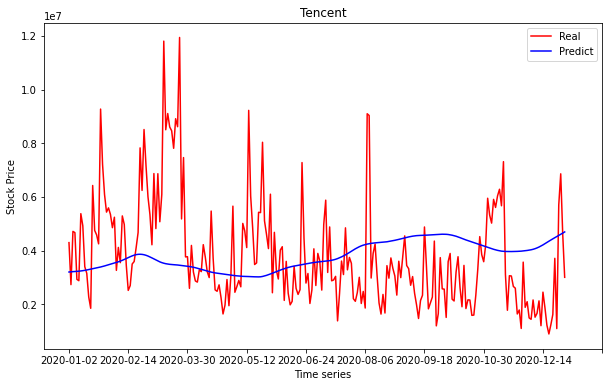

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Intel]=-0.07612399089752508


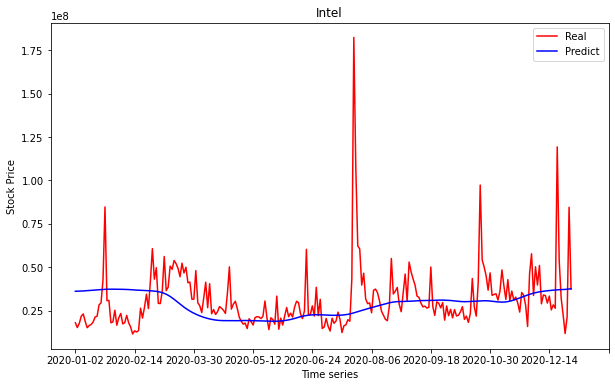

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Cisco]=-0.06944530944062


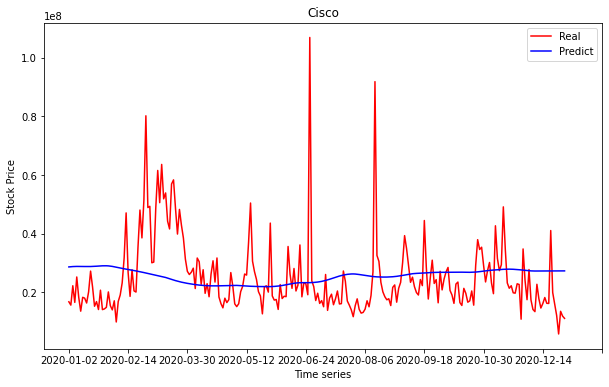

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Oracle]=-0.0971465664147797


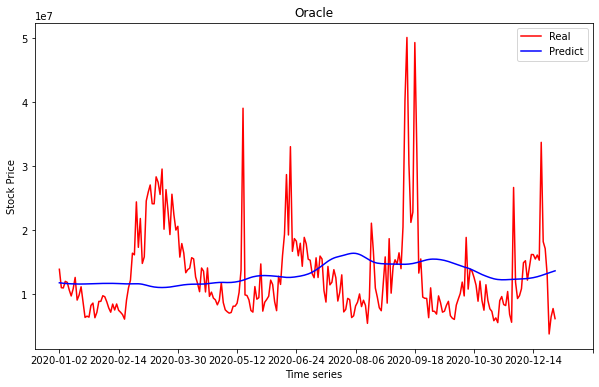

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[HP]=0.01687964673910758


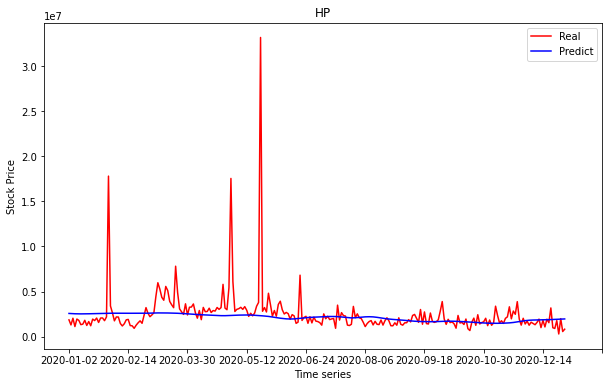

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Themo]=-0.037977436090565364


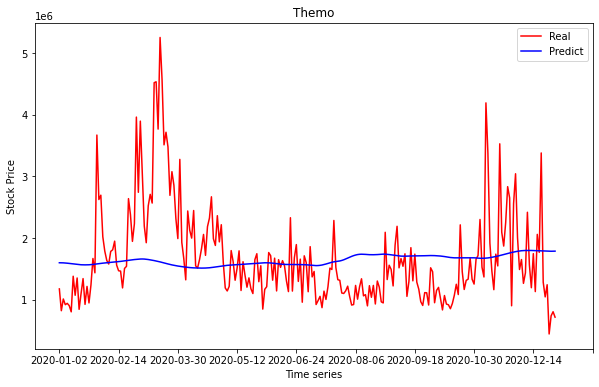

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Sony]=-0.08666472740283271


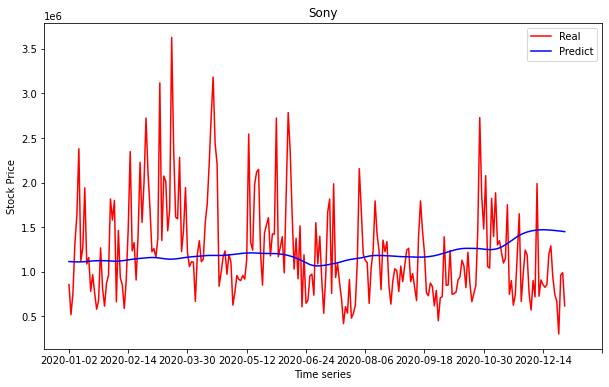

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[SAP]=0.017433845425773975


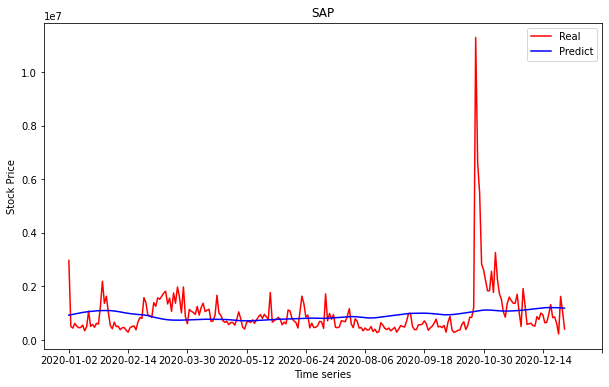

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Dell]=-0.04396525371681159


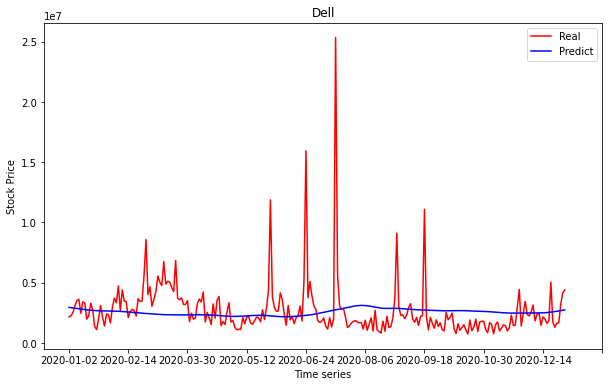

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[IBM]=0.025349636756906158


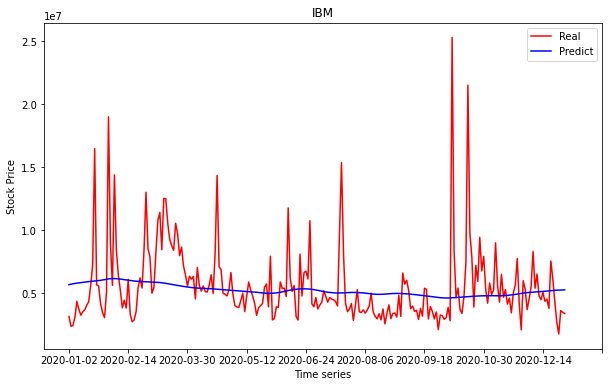

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[HPE]=-0.07252370470339708


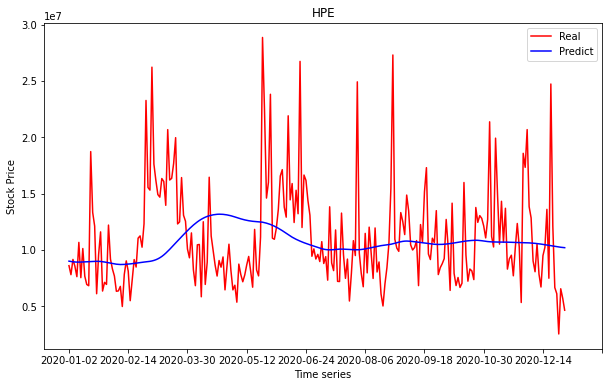

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Accenture]=-0.08848136430899989


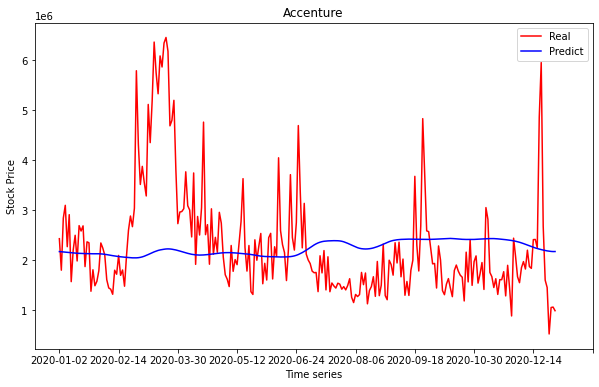

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Panasonic]=-0.0012572206289676036


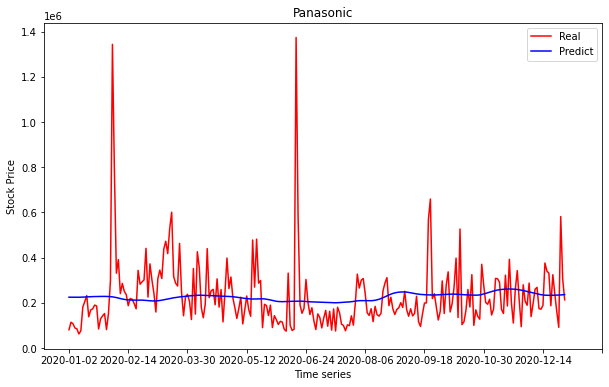

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Canon]=-0.2214791444313009


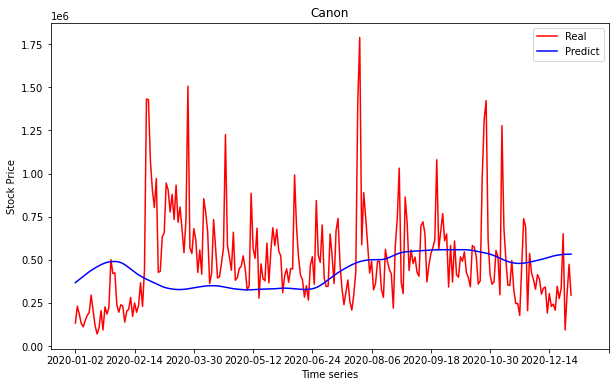

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Hon Hai]=-1.631748020991934


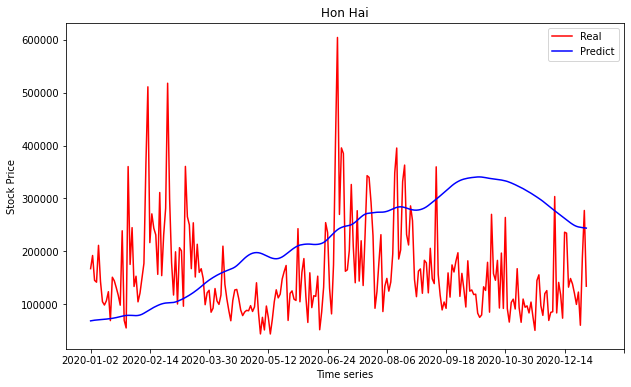

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Hitachi]=0.0623694964378847


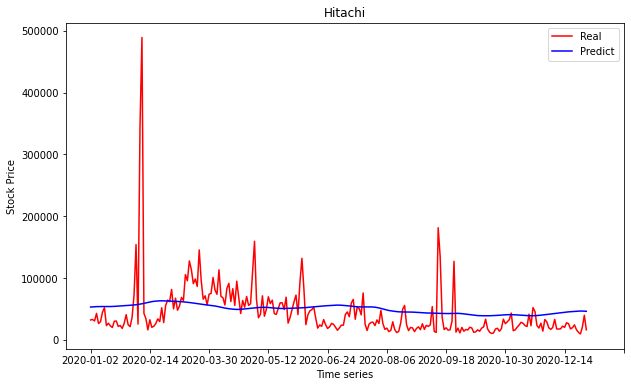

In [12]:
t1 = make_preds(c, nl, v, o1, o2, V=V, output_c=output_c, output_i=output_i, train_size=754, time_step=60)

In [13]:
output_c='High' # output item
output_i=items[output_c]-1
o3, o4 = make_models(c, nl, v, V=V, output_c=output_c, output_i=output_i, train_size=754, time_step=60, epochs=1)

train_data=(20, 754, 5), test_data=(20, 252, 5)
finish split data
volume=TRUE
ind=[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
X_train=(694, 60, 100), y_trains=(13880,)
finish making X_train and y_trains
y_trains2=(694,)
1/20
22/22 [==============================] - 9s 117ms/step - loss: 0.3314

2/20
22/22 [==============================] - 9s 114ms/step - loss: 0.4282

3/20
22/22 [==============================] - 9s 117ms/step - loss: 0.3459

4/20
22/22 [==============================] - 11s 112ms/step - loss: 0.4295

5/20
22/22 [==============================] - 9s 109ms/step - loss: 0.3672

6/20
22/22 [==============================] - 9s 115ms/step - loss: 0.4318

7/20
22/22 [==============================] - 9s 111ms/step - loss: 0.3377

8/20
22/22 [==============================] - 9s 117ms/step - loss: 0.3655

9/20
22/22 [==============================] - 9s 110ms/step - loss: 0.4319

10/20
22/22 [==============================] - 11s 112ms/step

train_data=(20, 754, 5), test_data=(20, 252, 5)
inputs = (20, 312, 5)
[0, 2, 3]
con=(312, 60)
ss_lists=41
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 1)
(312, 60)
X_test=(252, 60, 100)
finish making predictions
1
2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Facebook]=-0.13443343468654145


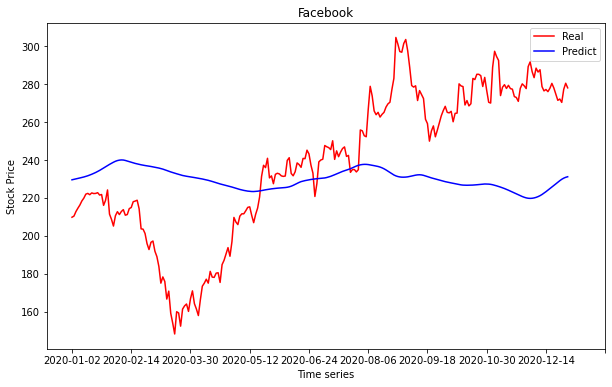

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Apple]=-0.010464605825951878


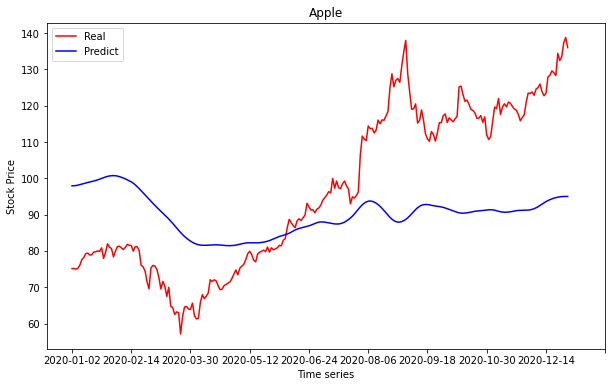

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Microsoft]=-0.3762319183441003


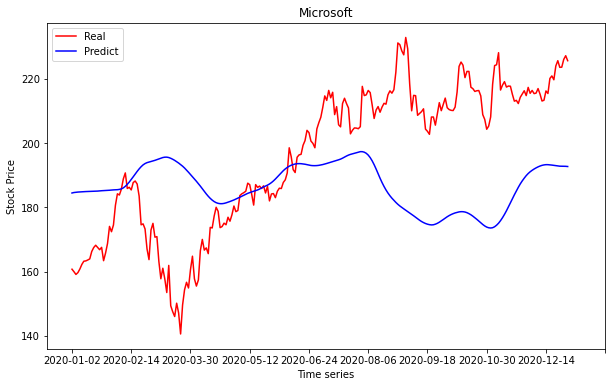

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[TSMC]=-0.10266735941578253


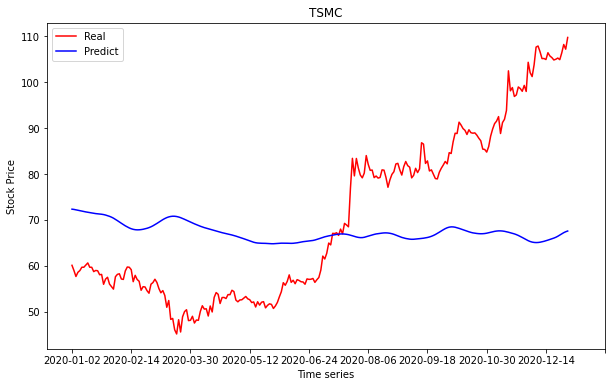

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Tencent]=0.07423778647990043


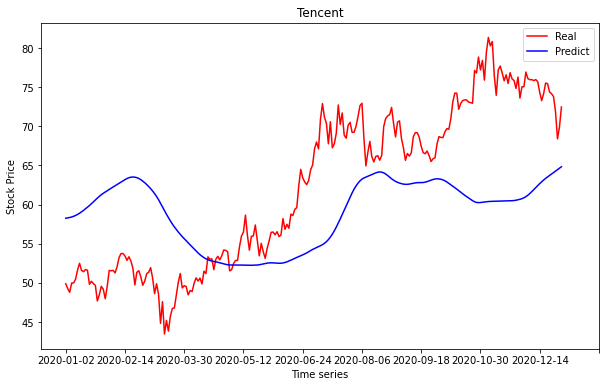

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Intel]=-0.416371725714227


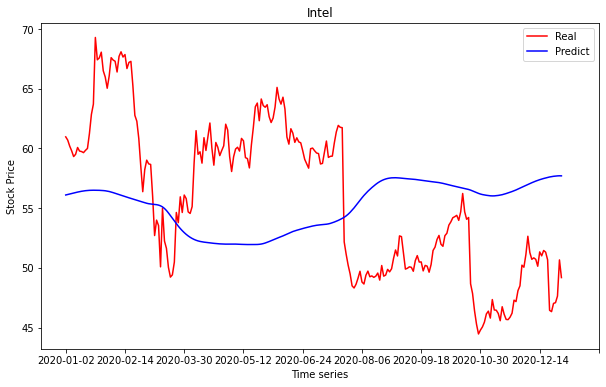

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Cisco]=-0.01960910638651625


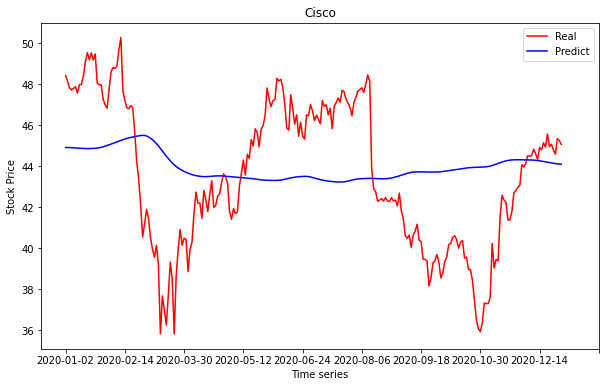

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Oracle]=0.08071320730684906


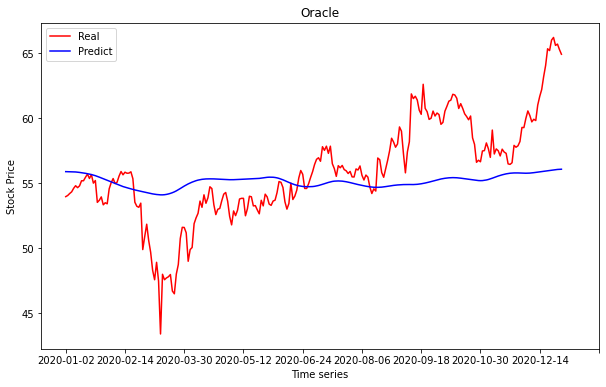

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[HP]=0.19034524653382268


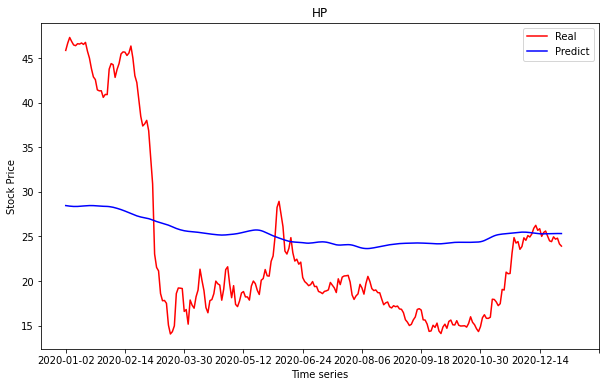

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Themo]=0.05221376914891762


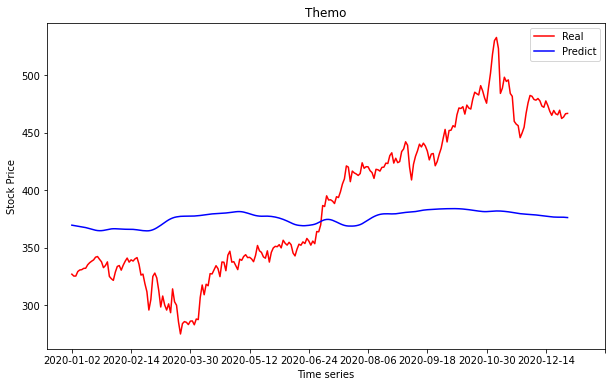

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Sony]=-0.1555242412757012


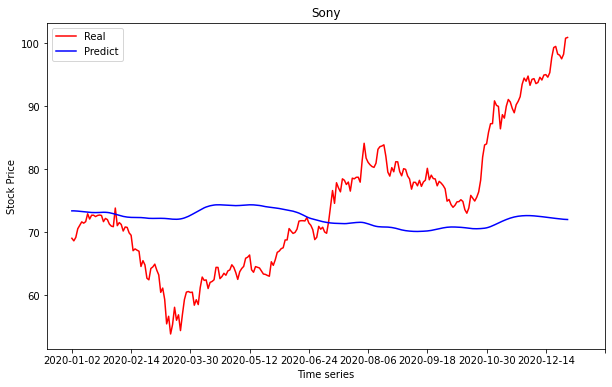

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[SAP]=-0.06638430234830262


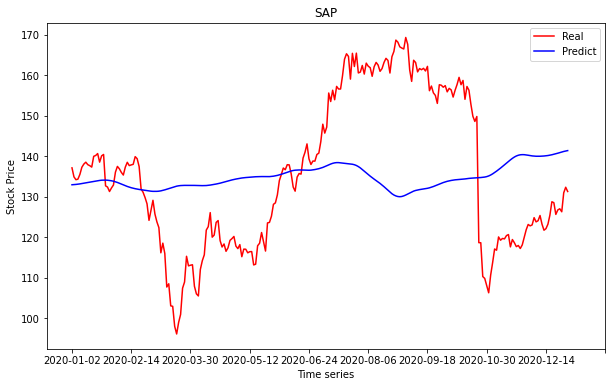

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Dell]=-0.019108250131727678


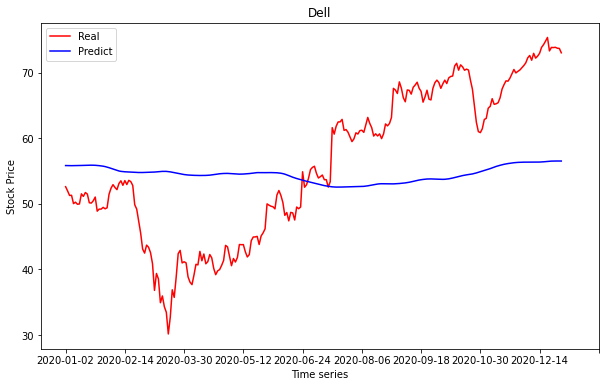

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[IBM]=-0.007503044885588839


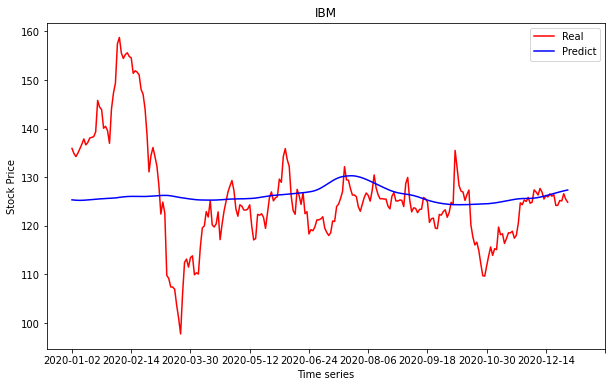

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[HPE]=-0.8654515642772189


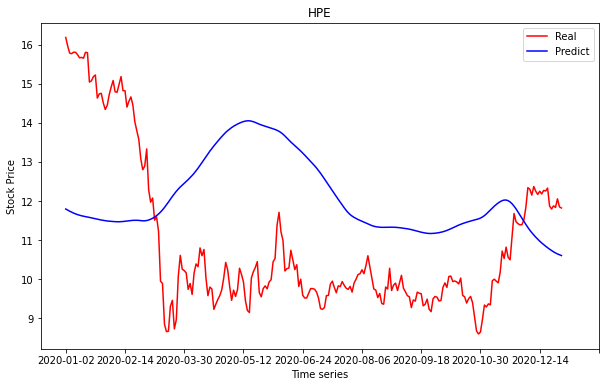

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Accenture]=0.07266481244830814


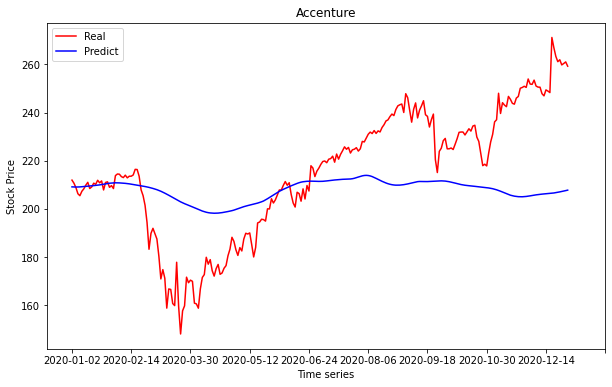

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Panasonic]=-0.05020825058927625


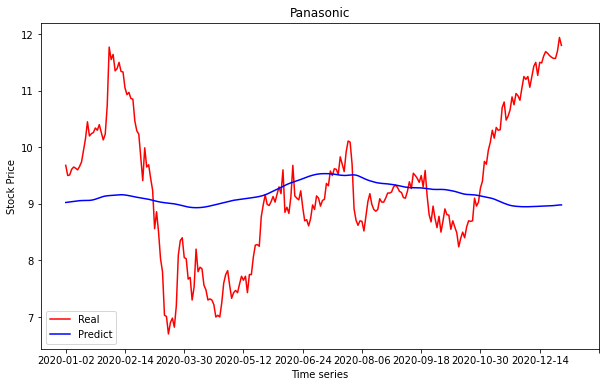

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Canon]=-0.1100919426074416


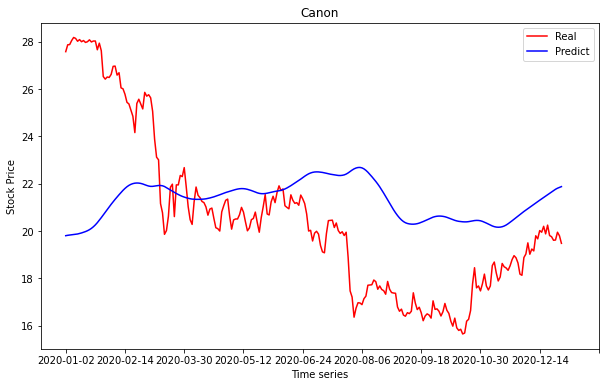

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Hon Hai]=0.03906595779438504


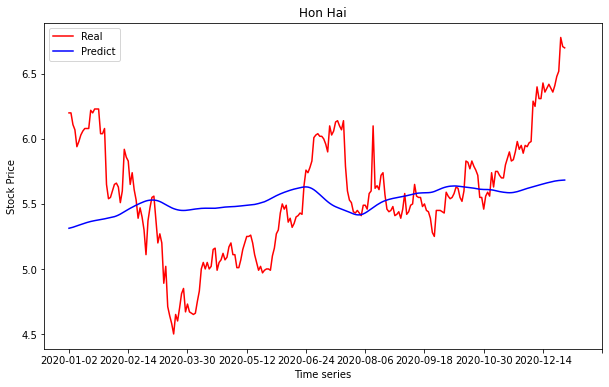

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Hitachi]=0.057662760952538084


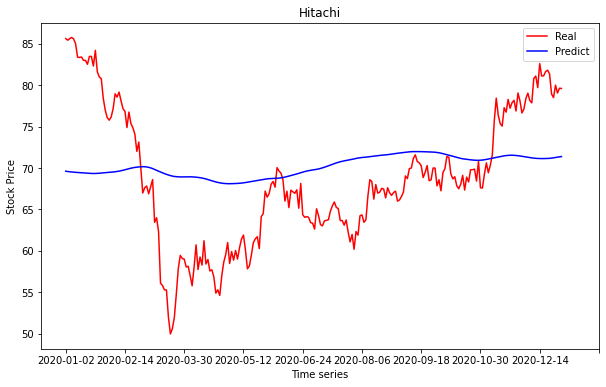

In [14]:
t2 = make_preds(c, nl, v, o1, o2, V=V, output_c=output_c, output_i=output_i, train_size=754, time_step=60)

In [ ]:
# correlation between 
from sklearn.metrics import r2_score
print(f"R2={r2_score(t1, t2)}")

R2=-135.99943646211506
